In [1]:
import pandas as pd 
import numpy as np 

import os

import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import seaborn as sns 
import missingno as msno 
from utils import my_histogram, make_stacked_table, my_stacked_barplot

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)

In [67]:
df_train = pd.read_csv("../data/df_train.csv")
df_test = pd.read_csv("../data/df_test.csv")

- There are 8 vital signs variables and 26 laboratory variables.
    - Vital signs
        - HR: Heart rate (beats per minute)
        - O2Sat: Pulse oximetry (%)
        - Temp: Temperature (Deg C)
        - SBP: Systolic BP (mm Hg)
        - MAP: Mean arterial pressure (mm Hg)
        - DBP: Diastolic BP (mm Hg)
        - Resp: Respiration rate (breaths per minute)
        - EtCO2: End tidal carbon dioxide (mm Hg)
    - Laboratory values
        - BaseExcess: Measure of excess bicarbonate (mmol/L)
        - HCO3: Bicarbonate (mmol/L)
        - FiO2: Fraction of inspired oxygen (%)
        - pH: N/A
        - PaCO2: Partial pressure of carbon dioxide from arterial blood (mm Hg)
        - SaO2: Oxygen saturation from arterial blood (%)
        - AST: Aspartate transaminase (IU/L)
        - BUN: Blood urea nitrogen (mg/dL)
        - Alkalinephos: Alkaline phosphatase (IU/L)
        - Calcium: (mg/dL)
        - Chloride: (mmol/L)
        - Creatinine: (mg/dL)
        - Bilirubin_direct: Bilirubin direct (mg/dL)
        - Glucose: Serum glucose (mg/dL)
        - Lactate: Lactic acid (mg/dL)
        - Magnesium: (mmol/dL)
        - Phosphate: (mg/dL)
        - Potassium: (mmol/L)
        - Bilirubin_total: Total bilirubin (mg/dL)
        - TroponinI: Troponin I (ng/mL)
        - Hct: Hematocrit (%)
        - Hgb: Hemoglobin (g/dL)
        - PTT: partial thromboplastin time (seconds)
        - WBC: Leukocyte count (count*10^3/µL)
        - Fibrinogen: (mg/dL)
        - Platelets: (count*10^3/µL)


# 1. Shock index & BUN/CR

- There are some researches that follwing features are important in predicting the sepsis (Henry, K. E., Hager, D. N., Pronovost, P. J., and Saria, S. A targeted real-time early warning score (trewscore) for septic shock. Science Translational Medicine 7, 299 (2015), 299ra122–299ra122.):
    - ShockIndex(t) = $\frac{\text{HR(t)}}{SBP(t)}$
    - BUN/CR(t) = $\frac{\text{BUN(t)}}{Creatinine(t)}$

- Let's make these features.

In [68]:
df_train["ShockIndex"] = df_train.HR / df_train.SBP
df_test["ShockIndex"] = df_test.HR / df_test.SBP

df_train["BUN/CR"] = df_train.BUN / df_train.Creatinine
df_test["BUN/CR"] = df_test.BUN / df_test.Creatinine


# 2. Measurement time

- Let's incorporate the measurment time information of each variables:
    - Beginning time: Time of the first measurment
    - End time: Time of the last measurment
    - Frequency: Ratio between the total number of the measurment and the maximum hour of the patient

In [50]:
target_col_list = ["ID", 'BUN', 'Creatinine', 'DBP', 'Gender', 'HR', 'Hct', 'Hgb',
                   'MAP', 'Magnesium', 'O2Sat', 'Phosphate', 'Platelets',
                   'Potassium', 'Resp', 'SBP', 'Temp', 'WBC', 'BaseExcess', 'Chloride',
                   'FiO2', 'Glucose', 'HCO3', 'PaCO2', 'SaO2', 'pH', 'Calcium',
                   'Fibrinogen', 'Lactate', 'PTT', 'TroponinI', 'AST', 'Alkalinephos',
                   'Bilirubin_total', 'EtCO2', 'Bilirubin_direct', 'ShockIndex','BUN/CR']

In [51]:
df_train_measurment_time_info = df_train[["ID"]].drop_duplicates()
df_test_measurment_time_info = df_test[["ID"]].drop_duplicates()

In [52]:
for target_col in target_col_list:
    begin_time = df_train[~df_train[target_col].isna()].groupby("ID").Hour.min().reset_index()
    end_time = df_train[~df_train[target_col].isna()].groupby("ID").Hour.max().reset_index()
    freq = (df_train[~df_train[target_col].isna()].groupby("ID").Hour.count() / df_train.groupby("ID").Hour.count()).reset_index()
    
    df_train_measurment_time_info = df_train_measurment_time_info.merge(begin_time.rename(columns = {"Hour": f"{target_col}_beg_time"}), how = "left", on = "ID") \
                                                                 .merge(end_time.rename(columns = {"Hour": f"{target_col}_end_time"}), how = "left", on = "ID") \
                                                                 .merge(freq.rename(columns = {"Hour": f"{target_col}_freq"}), how = "left", on = "ID") 
                                                      


In [54]:
for target_col in target_col_list:
    begin_time = df_test[~df_test[target_col].isna()].groupby("ID").Hour.min().reset_index()
    end_time = df_test[~df_test[target_col].isna()].groupby("ID").Hour.max().reset_index()
    freq = (df_test[~df_test[target_col].isna()].groupby("ID").Hour.count() / df_test.groupby("ID").Hour.count()).reset_index()
    
    df_test_measurment_time_info = df_test_measurment_time_info.merge(begin_time.rename(columns = {"Hour": f"{target_col}_beg_time"}), how = "left", on = "ID") \
                                                               .merge(end_time.rename(columns = {"Hour": f"{target_col}_end_time"}), how = "left", on = "ID") \
                                                               .merge(freq.rename(columns = {"Hour": f"{target_col}_freq"}), how = "left", on = "ID")


- Also merge the information that shows how long each patient has stayed (the maximum hour of each patient).

In [61]:
df_train_measurment_time_info = df_train_measurment_time_info.merge(df_train.groupby("ID").Hour.count().reset_index().rename(columns = {"Hour": "length_of_stay"}),
                                                                    how = "left", on = "ID")

In [62]:
df_test_measurment_time_info = df_test_measurment_time_info.merge(df_test.groupby("ID").Hour.count().reset_index().rename(columns = {"Hour": "length_of_stay"}),
                                                                  how = "left", on = "ID")

In [144]:
df_train_measurment_time_info

,ID,BUN_beg_time,BUN_end_time,BUN_freq,Creatinine_beg_time,Creatinine_end_time,Creatinine_freq,DBP_beg_time,DBP_end_time,DBP_freq,Gender_beg_time,Gender_end_time,Gender_freq,HR_beg_time,HR_end_time,HR_freq,Hct_beg_time,Hct_end_time,Hct_freq,Hgb_beg_time,Hgb_end_time,Hgb_freq,ID_beg_time,ID_end_time,ID_freq,MAP_beg_time,MAP_end_time,MAP_freq,Magnesium_beg_time,Magnesium_end_time,Magnesium_freq,O2Sat_beg_time,O2Sat_end_time,O2Sat_freq,Phosphate_beg_time,Phosphate_end_time,Phosphate_freq,Platelets_beg_time,Platelets_end_time,Platelets_freq,Potassium_beg_time,Potassium_end_time,Potassium_freq,Resp_beg_time,Resp_end_time,Resp_freq,SBP_beg_time,SBP_end_time,SBP_freq,Temp_beg_time,Temp_end_time,Temp_freq,WBC_beg_time,WBC_end_time,WBC_freq,BaseExcess_beg_time,BaseExcess_end_time,BaseExcess_freq,Chloride_beg_time,Chloride_end_time,Chloride_freq,FiO2_beg_time,FiO2_end_time,FiO2_freq,Glucose_beg_time,Glucose_end_time,Glucose_freq,HCO3_beg_time,HCO3_end_time,HCO3_freq,PaCO2_beg_time,PaCO2_end_time,PaCO2_freq,SaO2_beg_time,SaO2_end_time,SaO2_freq,pH_beg_time,pH_end_time,pH_freq,Calcium_beg_time,Calcium_end_time,Calcium_freq,Fibrinogen_beg_time,Fibrinogen_end_time,Fibrinogen_freq,Lactate_beg_time,Lactate_end_time,Lactate_freq,PTT_beg_time,PTT_end_time,PTT_freq,TroponinI_beg_time,TroponinI_end_time,TroponinI_freq,AST_beg_time,AST_end_time,AST_freq,Alkalinephos_beg_time,Alkalinephos_end_time,Alkalinephos_freq,Bilirubin_total_beg_time,Bilirubin_total_end_time,Bilirubin_total_freq,EtCO2_beg_time,EtCO2_end_time,EtCO2_freq,Bilirubin_direct_beg_time,Bilirubin_direct_end_time,Bilirubin_direct_freq,ShockIndex_beg_time,ShockIndex_end_time,ShockIndex_freq,BUN/CR_beg_time,BUN/CR_end_time,BUN/CR_freq,length_of_stay
0,2,17.0,18.0,0.090909,17.0,17.0,0.045455,4.0,24.0,0.909091,1,24,1.0,4.0,24.0,0.909091,11.0,18.0,0.181818,17.0,18.0,0.090909,1,24,1.0,4.0,24.0,0.909091,NaN,NaN,NaN,4.0,24.0,0.909091,NaN,NaN,NaN,NaN,NaN,NaN,17.0,18.0,0.090909,4.0,24.0,0.909091,4.0,24.0,0.863636,5.0,23.0,0.409091,17.0,18.0,0.090909,4.0,5.0,0.090909,17.0,18.0,0.090909,4.0,5.0,0.090909,4.0,17.0,0.090909,17.0,18.0,0.090909,4.0,4.0,0.045455,4.0,5.0,0.090909,4.0,5.0,0.090909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,24.0,0.863636,17.0,17.0,0.045455,22
1,3,15.0,38.0,0.051724,15.0,38.0,0.051724,2.0,41.0,0.568966,1,58,1.0,2.0,58.0,0.862069,15.0,38.0,0.137931,15.0,38.0,0.137931,1,58,1.0,2.0,58.0,0.896552,8.0,48.0,0.086207,2.0,58.0,0.620690,15.0,15.0,0.017241,15.0,38.0,0.086207,8.0,48.0,0.172414,2.0,58.0,0.879310,2.0,58.0,0.879310,4.0,56.0,0.500000,15.0,38.0,0.068966,9.0,40.0,0.189655,15.0,38.0,0.051724,22.0,25.0,0.051724,8.0,48.0,0.189655,15.0,22.0,0.034483,9.0,40.0,0.189655,22.0,40.0,0.120690,9.0,40.0,0.189655,8.0,48.0,0.051724,15.0,21.0,0.034483,9.0,25.0,0.086207,15.0,38.0,0.068966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,58.0,0.827586,15.0,38.0,0.051724,58
2,4,NaN,NaN,NaN,16.0,16.0,0.026316,2.0,38.0,0.947368,1,38,1.0,2.0,38.0,0.868421,16.0,16.0,0.026316,16.0,16.0,0.026316,1,38,1.0,2.0,38.0,0.921053,NaN,NaN,NaN,2.0,38.0,0.894737,NaN,NaN,NaN,NaN,NaN,NaN,16.0,16.0,0.026316,2.0,38.0,0.947368,2.0,38.0,0.868421,3.0,35.0,0.184211,16.0,16.0,0.026316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,32.0,0.184211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,16.0,0.026316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,27.0,0.026316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,38.0,0.789474,NaN,NaN,NaN,38
3,5,6.0,124.0,0.044776,6.0,124.0,0.044776,2.0,134.0,0.902985,1,134,1.0,2.0,134.0,0.940299,6.0,124.0,0.044776,6.0,124.0,0.044776,1,134,1.0,2.0,134.0,0.955224,6.0,124.0,0.044776,2.0,134.0,0.880597,6.0,124.0,0.037313,31.0,124.0,0.029851,6.0,124.0,0.067164,3.0,134.0,0.917910,2.0,133.0,0.917910,2.0,134.0,0.231343,6.0,124.0,0.044776,NaN,NaN,NaN,NaN,NaN,NaN,48.0,133.0,0.097015,6.0,130.0,0.186567,NaN,NaN,NaN,39.0,133.0,0.104478,31.0,133.0,0.104478,31.0,133.0,0.104478,6.0,124.

In [145]:
df_test_measurment_time_info

,ID,BUN_beg_time,BUN_end_time,BUN_freq,Creatinine_beg_time,Creatinine_end_time,Creatinine_freq,DBP_beg_time,DBP_end_time,DBP_freq,Gender_beg_time,Gender_end_time,Gender_freq,HR_beg_time,HR_end_time,HR_freq,Hct_beg_time,Hct_end_time,Hct_freq,Hgb_beg_time,Hgb_end_time,Hgb_freq,ID_beg_time,ID_end_time,ID_freq,MAP_beg_time,MAP_end_time,MAP_freq,Magnesium_beg_time,Magnesium_end_time,Magnesium_freq,O2Sat_beg_time,O2Sat_end_time,O2Sat_freq,Phosphate_beg_time,Phosphate_end_time,Phosphate_freq,Platelets_beg_time,Platelets_end_time,Platelets_freq,Potassium_beg_time,Potassium_end_time,Potassium_freq,Resp_beg_time,Resp_end_time,Resp_freq,SBP_beg_time,SBP_end_time,SBP_freq,Temp_beg_time,Temp_end_time,Temp_freq,WBC_beg_time,WBC_end_time,WBC_freq,BaseExcess_beg_time,BaseExcess_end_time,BaseExcess_freq,Chloride_beg_time,Chloride_end_time,Chloride_freq,FiO2_beg_time,FiO2_end_time,FiO2_freq,Glucose_beg_time,Glucose_end_time,Glucose_freq,HCO3_beg_time,HCO3_end_time,HCO3_freq,PaCO2_beg_time,PaCO2_end_time,PaCO2_freq,SaO2_beg_time,SaO2_end_time,SaO2_freq,pH_beg_time,pH_end_time,pH_freq,Calcium_beg_time,Calcium_end_time,Calcium_freq,Fibrinogen_beg_time,Fibrinogen_end_time,Fibrinogen_freq,Lactate_beg_time,Lactate_end_time,Lactate_freq,PTT_beg_time,PTT_end_time,PTT_freq,TroponinI_beg_time,TroponinI_end_time,TroponinI_freq,AST_beg_time,AST_end_time,AST_freq,Alkalinephos_beg_time,Alkalinephos_end_time,Alkalinephos_freq,Bilirubin_total_beg_time,Bilirubin_total_end_time,Bilirubin_total_freq,EtCO2_beg_time,EtCO2_end_time,EtCO2_freq,Bilirubin_direct_beg_time,Bilirubin_direct_end_time,Bilirubin_direct_freq,ShockIndex_beg_time,ShockIndex_end_time,ShockIndex_freq,BUN/CR_beg_time,BUN/CR_end_time,BUN/CR_freq,length_of_stay
0,1,5.0,5.0,0.058824,5.0,5.0,0.058824,2.0,17.0,0.823529,1,17,1.0,2.0,17.0,0.941176,5.0,5.0,0.058824,5.0,5.0,0.058824,1,17,1.0,2.0,17.0,0.882353,5.0,5.0,0.058824,2.0,17.0,0.882353,5.0,5.0,0.058824,5.0,5.0,0.058824,5.0,5.0,0.058824,2.0,17.0,0.823529,2.0,17.0,0.882353,2.0,14.0,0.176471,5.0,5.0,0.058824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,17.0,0.882353,5.0,5.0,0.058824,17
1,8,12.0,12.0,0.058824,12.0,12.0,0.058824,2.0,17.0,0.823529,1,17,1.0,2.0,17.0,0.764706,12.0,12.0,0.058824,12.0,12.0,0.058824,1,17,1.0,2.0,17.0,0.941176,NaN,NaN,NaN,2.0,17.0,0.882353,NaN,NaN,NaN,12.0,12.0,0.058824,12.0,12.0,0.058824,2.0,17.0,0.941176,2.0,17.0,0.941176,8.0,16.0,0.176471,12.0,12.0,0.058824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,0.058824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,0.058824,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,0.058824,NaN,NaN,NaN,12.0,12.0,0.058824,NaN,NaN,NaN,12.0,12.0,0.058824,NaN,NaN,NaN,NaN,NaN,NaN,2.0,17.0,0.764706,12.0,12.0,0.058824,17
2,9,15.0,15.0,0.045455,15.0,15.0,0.045455,2.0,22.0,0.818182,1,22,1.0,2.0,21.0,0.818182,15.0,15.0,0.045455,15.0,15.0,0.045455,1,22,1.0,2.0,22.0,0.863636,15.0,15.0,0.045455,2.0,22.0,0.909091,15.0,15.0,0.045455,NaN,NaN,NaN,15.0,15.0,0.045455,2.0,22.0,0.909091,2.0,22.0,0.909091,2.0,22.0,0.909091,15.0,15.0,0.045455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,21.0,0.409091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,15.0,0.045455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,0.181818,NaN,NaN,NaN,2.0,21.0,0.772727,15.0,15.0,0.045455,22
3,10,2.0,30.0,0.066667,2.0,30.0,0.066667,2.0,45.0,0.977778,1,45,1.0,2.0,45.0,0.955556,2.0,30.0,0.066667,2.0,30.0,0.066667,1,45,1.0,2.0,45.0,0.955556,2.0,30.0,0.066667,2.0,45.0,0.911111,2.0,8.0,0.044444,2.0,30.0,0.066667,2.0,30.0,0.088889,2.0,45.0,0.933333,2.0,45.0,0.866667,2.0,44.0,0.333333,2.0,30.0,0.066667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,40.0,0.177778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,30.0,0.066667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,0.022222,2.0,8.0,0.044444,2.0,8.0,0.044444,2.0,8.0,0.044444,NaN,NaN,NaN

- Save the tables.

In [63]:
df_train_measurment_time_info.to_csv("../data/df_train_measurment_time_info.csv", index = False)
df_test_measurment_time_info.to_csv("../data/df_test_measurment_time_info.csv", index = False)

# 3. Summary statistics

<AxesSubplot:>

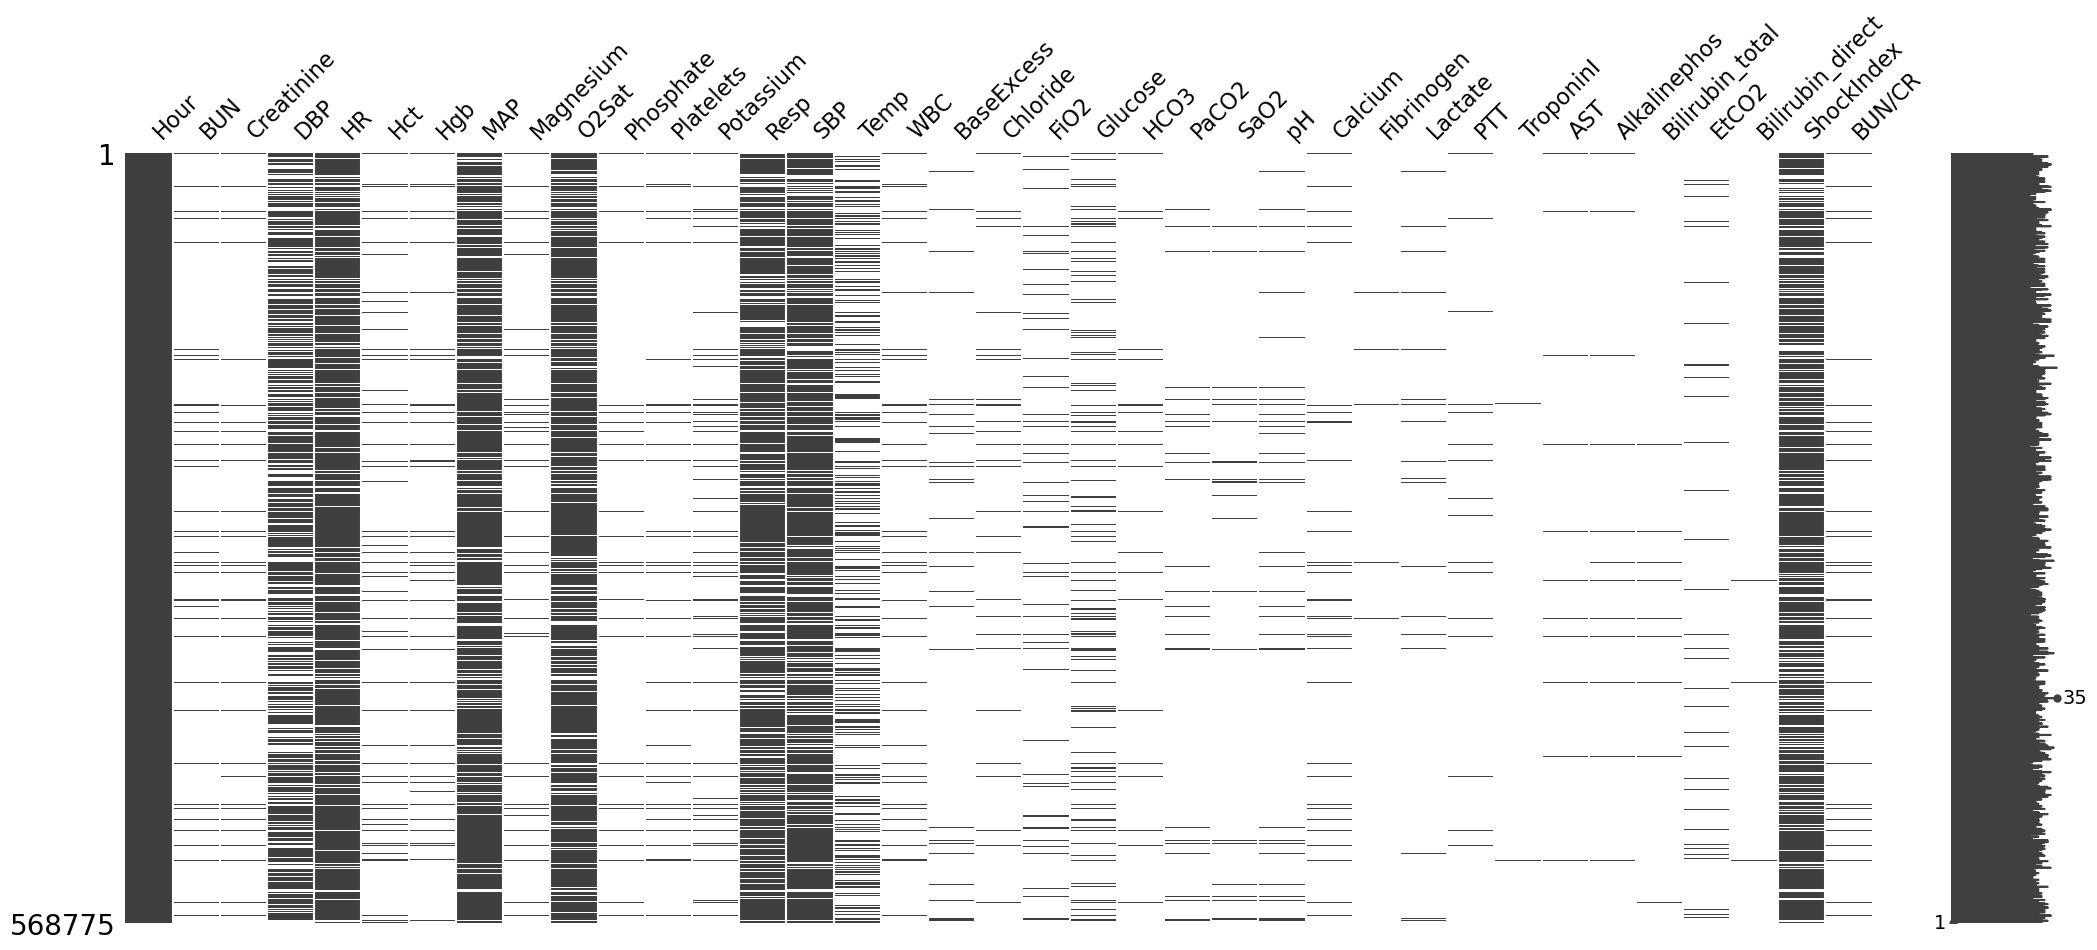

In [69]:
msno.matrix(df_train.drop(["Age", "Gender", "Outcome", "ID"], axis = 1))

- Because each variable is recorded only when it is measured, there are many missing values.
- Since variables are measured in several time for each patient, this is the dependent dataset. That is, there are correlations between measured values from same patient.
- So let's use summary statistics like minimum, maximum, mean, median, standard deviation for each variable instead of several measured variables for each patient.

- Before extract the summary statistics, let's impute the missing values.


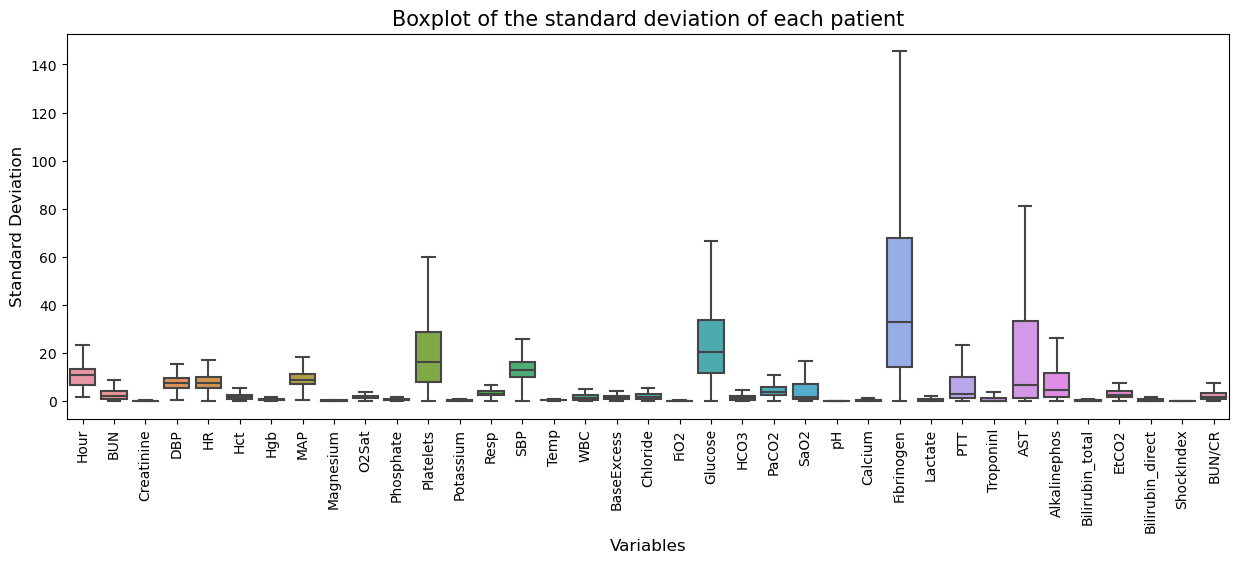

In [83]:
plt.figure(figsize = (15, 5))
sns.boxplot(df_train.drop(["Age", "Gender", "Outcome"], axis = 1).groupby("ID").std(), showfliers = False)
plt.ylabel("Standard Deviation", fontsize = 12)
plt.xlabel("Variables", fontsize = 12)
plt.title("Boxplot of the standard deviation of each patient", fontsize = 15)
plt.xticks(rotation = 90)
plt.show()

- Above plot shows the standard deviation distribution of each patient's measurements.
- It can be seen that the standard deviation of patients for almost all variables is very low.
- That is, there is no significant change in the measurement within the same patient.
- So, let's impute the missing values by the forward filling method which assumed the measurement value remained constant until the next measurement.

In [107]:
target_col_list = ["ID", "Hour", 'BUN', 'Creatinine', 'DBP', 'HR', 'Hct', 'Hgb',
                   'MAP', 'Magnesium', 'O2Sat', 'Phosphate', 'Platelets',
                   'Potassium', 'Resp', 'SBP', 'Temp', 'WBC', 'BaseExcess', 'Chloride',
                   'FiO2', 'Glucose', 'HCO3', 'PaCO2', 'SaO2', 'pH', 'Calcium',
                   'Fibrinogen', 'Lactate', 'PTT', 'TroponinI', 'AST', 'Alkalinephos',
                   'Bilirubin_total', 'EtCO2', 'Bilirubin_direct', 'ShockIndex','BUN/CR']

In [108]:
measurement_variable_train = df_train[target_col_list].sort_values(["ID", "Hour"])
measurement_variable_test = df_test[target_col_list].sort_values(["ID", "Hour"])

In [111]:
measurement_variable_train["ID_for_groupby"] = measurement_variable_train.ID
measurement_variable_test["ID_for_groupby"] = measurement_variable_test.ID

measurement_variable_train = measurement_variable_train.groupby("ID_for_groupby").transform(lambda v: v.ffill())
measurement_variable_test = measurement_variable_test.groupby("ID_for_groupby").transform(lambda v: v.ffill())

measurement_variable_train.drop("Hour", axis = 1, inplace = True)
measurement_variable_test.drop("Hour", axis = 1, inplace = True)

- Now let's extract the summary statistics of each patient.

In [130]:
# features for train data

grouped_mean = measurement_variable_train.groupby("ID").mean()
grouped_std = measurement_variable_train.groupby("ID").std()
grouped_min = measurement_variable_train.groupby("ID").min()
grouped_max = measurement_variable_train.groupby("ID").max()

for col in grouped_mean.columns:
    grouped_mean = grouped_mean.rename(columns = {col: f"{col}_mean"})
    grouped_std = grouped_std.rename(columns = {col: f"{col}_std"})
    grouped_min = grouped_min.rename(columns = {col: f"{col}_min"})
    grouped_max = grouped_max.rename(columns = {col: f"{col}_max"})

df_train_measurement_grouped_stat = measurement_variable_train[["ID"]].drop_duplicates()
df_train_measurement_grouped_stat = df_train_measurement_grouped_stat.merge(grouped_mean, how = "left", on = "ID") \
                                                                     .merge(grouped_std, how = "left", on = "ID") \
                                                                     .merge(grouped_min, how = "left", on = "ID") \
                                                                     .merge(grouped_max, how = "left", on = "ID") 
                                                                     

In [139]:
# features for test data

grouped_mean = measurement_variable_test.groupby("ID").mean()
grouped_std = measurement_variable_test.groupby("ID").std()
grouped_min = measurement_variable_test.groupby("ID").min()
grouped_max = measurement_variable_test.groupby("ID").max()

for col in grouped_mean.columns:
    grouped_mean = grouped_mean.rename(columns = {col: f"{col}_mean"})
    grouped_std = grouped_std.rename(columns = {col: f"{col}_std"})
    grouped_min = grouped_min.rename(columns = {col: f"{col}_min"})
    grouped_max = grouped_max.rename(columns = {col: f"{col}_max"})

df_test_measurment_grouped_stat = measurement_variable_test[["ID"]].drop_duplicates()
df_test_measurment_grouped_stat = df_test_measurment_grouped_stat.merge(grouped_mean, how = "left", on = "ID") \
                                                                 .merge(grouped_std, how = "left", on = "ID") \
                                                                 .merge(grouped_min, how = "left", on = "ID") \
                                                                 .merge(grouped_max, how = "left", on = "ID") 

In [140]:
df_train_measurement_grouped_stat

,ID,BUN_mean,Creatinine_mean,DBP_mean,HR_mean,Hct_mean,Hgb_mean,MAP_mean,Magnesium_mean,O2Sat_mean,Phosphate_mean,Platelets_mean,Potassium_mean,Resp_mean,SBP_mean,Temp_mean,WBC_mean,BaseExcess_mean,Chloride_mean,FiO2_mean,Glucose_mean,HCO3_mean,PaCO2_mean,SaO2_mean,pH_mean,Calcium_mean,Fibrinogen_mean,Lactate_mean,PTT_mean,TroponinI_mean,AST_mean,Alkalinephos_mean,Bilirubin_total_mean,EtCO2_mean,Bilirubin_direct_mean,ShockIndex_mean,BUN/CR_mean,BUN_std,Creatinine_std,DBP_std,HR_std,Hct_std,Hgb_std,MAP_std,Magnesium_std,O2Sat_std,Phosphate_std,Platelets_std,Potassium_std,Resp_std,SBP_std,Temp_std,WBC_std,BaseExcess_std,Chloride_std,FiO2_std,Glucose_std,HCO3_std,PaCO2_std,SaO2_std,pH_std,Calcium_std,Fibrinogen_std,Lactate_std,PTT_std,TroponinI_std,AST_std,Alkalinephos_std,Bilirubin_total_std,EtCO2_std,Bilirubin_direct_std,ShockIndex_std,BUN/CR_std,BUN_min,Creatinine_min,DBP_min,HR_min,Hct_min,Hgb_min,MAP_min,Magnesium_min,O2Sat_min,Phosphate_min,Platelets_min,Potassium_min,Resp_min,SBP_min,Temp_min,WBC_min,BaseExcess_min,Chloride_min,FiO2_min,Glucose_min,HCO3_min,PaCO2_min,SaO2_min,pH_min,Calcium_min,Fibrinogen_min,Lactate_min,PTT_min,TroponinI_min,AST_min,Alkalinephos_min,Bilirubin_total_min,EtCO2_min,Bilirubin_direct_min,ShockIndex_min,BUN/CR_min,BUN_max,Creatinine_max,DBP_max,HR_max,Hct_max,Hgb_max,MAP_max,Magnesium_max,O2Sat_max,Phosphate_max,Platelets_max,Potassium_max,Resp_max,SBP_max,Temp_max,WBC_max,BaseExcess_max,Chloride_max,FiO2_max,Glucose_max,HCO3_max,PaCO2_max,SaO2_max,pH_max,Calcium_max,Fibrinogen_max,Lactate_max,PTT_max,TroponinI_max,AST_max,Alkalinephos_max,Bilirubin_total_max,EtCO2_max,Bilirubin_direct_max,ShockIndex_max,BUN/CR_max
0,2,12.166250,0.700000,58.893333,89.970476,27.213571,9.070000,75.272381,NaN,97.984762,NaN,NaN,4.471250,15.700476,115.151905,36.694000,8.036250,0.990000,107.468750,0.400000,125.801429,25.825000,37.500000,99.281429,7.443333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.789651,16.942857,0.123744,0.000000,8.480952,4.234100,1.497745,0.056569,7.690843,NaN,1.062688,NaN,NaN,0.003536,1.964122,10.043408,0.491993,0.045962,0.000000,0.003536,0.000000,15.032899,0.014142,0.000000,0.635014,0.030551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.088723,0.000000,11.86,0.70,46.93,74.78,25.96,9.05,60.12,NaN,95.93,NaN,NaN,4.47,11.41,99.02,35.61,8.02,0.99,107.46,0.40,107.10,25.79,37.50,96.51,7.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.614563,16.942857,12.21,0.70,79.91,95.72,28.89,9.21,90.60,NaN,100.06,NaN,NaN,4.48,19.98,132.76,37.41,8.15,0.99,107.47,0.40,137.31,25.83,37.50,99.42,7.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.966673,16.942857
1,3,9.179091,0.563636,67.792982,82.789474,30.123636,10.530909,76.083684,2.531176,96.276842,3.800000,212.173636,4.121765,17.965439,120.228070,36.999636,11.948864,2.123000,109.641136,0.412973,126.724314,25.850455,44.505600,78.998108,7.408200,8.430196,175.62,1.464400,37.180909,NaN,NaN,NaN,NaN,NaN,NaN,0.701669,16.400303,2.111585,0.048661,21.534443,14.053193,3.011037,1.034972,10.881973,0.383639,1.951691,0.000000,29.228191,0.386175,5.022348,15.108003,0.789538,2.762756,2.146345,6.127336,0.084422,32.436454,1.442959,4.729308,15.239642,0.033178,0.122466,36.734541,0.664272,12.378049,NaN,NaN,NaN,NaN,NaN,NaN,0.165108,3.771555,7.72,0.50,34.82,60.35,24.46,8.05,52.87,2.00,91.13,3.80,177.48,3.61,9.64,91.85,35.80,6.82,-2.86,104.39,0.39,50.39,25.23,31.13,65.03,7.37,8.21,161.19,0.88,23.81,NaN,NaN,NaN,NaN,NaN,NaN,0.494388,12.866667,13.76,0.60,97.18,111.08,40.50,13.51,109.62,3.11,100.17,3.80,281.18,5.04,34.05,160.07,38.28,13.94,12.85,117.54,0.75,169.06,29.13,49.32,98.44,7.51,8.51,267.01,3.63,52.77,NaN,NaN,NaN,NaN,NaN,NaN,1.118672,22.933333
2,4,NaN,0.750000,77.953514,106.853243,42.500000,14.200000,104.294324,NaN,95.424054,NaN,NaN,4.200000,23.717297,146.205676,36.891944,15.000000,NaN,NaN,NaN,212.999143,NaN,NaN,NaN,NaN,9.300000,NaN,NaN,NaN,0.07,NaN,NaN,NaN,NaN,NaN,0.726613,NaN,NaN,0.000000,9.103789,8.915002,0.000000,0.000000,7.853111,NaN,1.396676,NaN,NaN,0.000000,6.562330,12.773692,0.320114,0.00000

In [141]:
df_test_measurment_grouped_stat

,ID,BUN_mean,Creatinine_mean,DBP_mean,HR_mean,Hct_mean,Hgb_mean,MAP_mean,Magnesium_mean,O2Sat_mean,Phosphate_mean,Platelets_mean,Potassium_mean,Resp_mean,SBP_mean,Temp_mean,WBC_mean,BaseExcess_mean,Chloride_mean,FiO2_mean,Glucose_mean,HCO3_mean,PaCO2_mean,SaO2_mean,pH_mean,Calcium_mean,Fibrinogen_mean,Lactate_mean,PTT_mean,TroponinI_mean,AST_mean,Alkalinephos_mean,Bilirubin_total_mean,EtCO2_mean,Bilirubin_direct_mean,ShockIndex_mean,BUN/CR_mean,BUN_std,Creatinine_std,DBP_std,HR_std,Hct_std,Hgb_std,MAP_std,Magnesium_std,O2Sat_std,Phosphate_std,Platelets_std,Potassium_std,Resp_std,SBP_std,Temp_std,WBC_std,BaseExcess_std,Chloride_std,FiO2_std,Glucose_std,HCO3_std,PaCO2_std,SaO2_std,pH_std,Calcium_std,Fibrinogen_std,Lactate_std,PTT_std,TroponinI_std,AST_std,Alkalinephos_std,Bilirubin_total_std,EtCO2_std,Bilirubin_direct_std,ShockIndex_std,BUN/CR_std,BUN_min,Creatinine_min,DBP_min,HR_min,Hct_min,Hgb_min,MAP_min,Magnesium_min,O2Sat_min,Phosphate_min,Platelets_min,Potassium_min,Resp_min,SBP_min,Temp_min,WBC_min,BaseExcess_min,Chloride_min,FiO2_min,Glucose_min,HCO3_min,PaCO2_min,SaO2_min,pH_min,Calcium_min,Fibrinogen_min,Lactate_min,PTT_min,TroponinI_min,AST_min,Alkalinephos_min,Bilirubin_total_min,EtCO2_min,Bilirubin_direct_min,ShockIndex_min,BUN/CR_min,BUN_max,Creatinine_max,DBP_max,HR_max,Hct_max,Hgb_max,MAP_max,Magnesium_max,O2Sat_max,Phosphate_max,Platelets_max,Potassium_max,Resp_max,SBP_max,Temp_max,WBC_max,BaseExcess_max,Chloride_max,FiO2_max,Glucose_max,HCO3_max,PaCO2_max,SaO2_max,pH_max,Calcium_max,Fibrinogen_max,Lactate_max,PTT_max,TroponinI_max,AST_max,Alkalinephos_max,Bilirubin_total_max,EtCO2_max,Bilirubin_direct_max,ShockIndex_max,BUN/CR_max
0,1,15.000000,0.500000,61.455000,68.331250,40.900000,13.200000,76.487500,1.800000,98.219375,2.900000,225.000000,4.200000,17.570000,101.213750,36.405000,13.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.689517,30.000000,0.000000,0.000000,8.286606,5.288396,0.000000,0.000000,8.851043,0.000000,1.092389,0.000000,0.000000,0.000000,2.225396,13.608519,0.264273,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116445,0.000000,15.00,0.50,47.22,62.81,40.90,13.20,58.35,1.80,96.09,2.90,225.00,4.20,14.87,78.92,35.97,13.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.463434,30.000000,15.00,0.50,78.62,81.82,40.90,13.20,92.72,1.80,100.03,2.90,225.00,4.20,24.02,138.79,36.59,13.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.942473,30.000000
1,8,17.000000,1.060000,66.039375,88.433750,40.700000,13.500000,86.524375,NaN,99.448125,NaN,277.000000,4.100000,19.163750,117.705625,37.156000,13.300000,NaN,NaN,NaN,124.000000,NaN,NaN,NaN,NaN,8.500000,NaN,NaN,26.900000,NaN,22.000000,NaN,0.800000,NaN,NaN,0.750828,16.037736,0.000000,0.000000,10.893168,5.578247,0.000000,0.000000,8.370411,NaN,0.601922,NaN,0.000000,0.000000,2.500392,20.274020,0.169784,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,0.120591,0.000000,17.00,1.06,51.04,77.92,40.70,13.50,73.61,NaN,98.01,NaN,277.00,4.10,14.43,84.59,36.84,13.30,NaN,NaN,NaN,124.00,NaN,NaN,NaN,NaN,8.50,NaN,NaN,26.90,NaN,22.00,NaN,0.80,NaN,NaN,0.580072,16.037736,17.00,1.06,93.69,95.37,40.70,13.50,101.77,NaN,100.05,NaN,277.00,4.10,23.09,151.36,37.27,13.30,NaN,NaN,NaN,124.00,NaN,NaN,NaN,NaN,8.50,NaN,NaN,26.90,NaN,22.00,NaN,0.80,NaN,NaN,1.028808,16.037736
2,9,12.000000,0.820000,63.160476,85.978571,37.000000,12.000000,82.332381,1.900000,95.824762,3.200000,NaN,4.100000,18.238571,113.933810,37.477619,10.600000,NaN,NaN,NaN,102.926000,NaN,NaN,NaN,NaN,8.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.78381,NaN,0.828778,14.634146,0.000000,0.000000,10.424580,6.495059,0.000000,0.000000,12.891510,0.000000,2.221931,0.000000,NaN,0.000000,3.181612,22.592903,0.571637,0.000000,NaN,NaN,NaN,6.901488,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.49778,NaN,0.487875,0.000000,12.00,0.82,26.71,72.63,37.00,12.00,61.42,1.90,91.

- Save the tables.

In [143]:
df_train_measurement_grouped_stat.to_csv("../data/df_train_measurement_grouped_stat.csv", index = False)
df_test_measurment_grouped_stat.to_csv("../data/df_test_measurment_grouped_stat.csv", index = False)

# 4. Summary

- Make 2 features based on the research (Henry, K. E., Hager, D. N., Pronovost, P. J., and Saria, S. A targeted real-time early warning score (trewscore) for septic shock. Science Translational Medicine 7, 299 (2015), 299ra122–299ra122.)
    - ShockIndex(t) = $\frac{\text{HR(t)}}{SBP(t)}$
    - BUN/CR(t) = $\frac{\text{BUN(t)}}{Creatinine(t)}$

- Incorporate the measurment time information of each variables:
    - Beginning time: Time of the first measurment
    - End time: Time of the last measurment
    - Frequency: Ratio between the total number of the measurment and the maximum hour of the patient
- Also merge the information that shows how long each patient has stayed (the maximum hour of each patient).

- Because each variable is recorded only when it is measured, there are many missing values.
- Since variables are measured in several time for each patient, this is the dependent dataset. That is, there are correlations between measured values from same patient.
- So use summary statistics like minimum, maximum, mean, and standard deviation for each variable instead of several measured variables for each patient.

![4.summary](../images/2.3.eda_summary.png)